# Домашнее задание к лекции "GAN's"

Сделайте генератор лиц аниме на основе датасета [https://www.kaggle.com/soumikrakshit/anime-faces text](https://www.kaggle.com/soumikrakshit/anime-faces)

(можно взять часть данных)


###  импорт библиотек

In [ ]:
import os
import time
import glob

from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
# # sns.set_style(style='whitegrid')
# device_num = 0
# torch.cuda.set_device(device_num)

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.2)


### загрузка данных

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p data

!cp /content/drive/MyDrive/anime/archive.zip data/

!unzip -o -qq data/archive.zip -d data/
!rm -rf data/data/data

In [ ]:
data_dir ='/content/data'
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(data_dir, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [ ]:
print('Всего изображений в датасете', len(train_ds))

Всего изображений в датасете 21551


In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

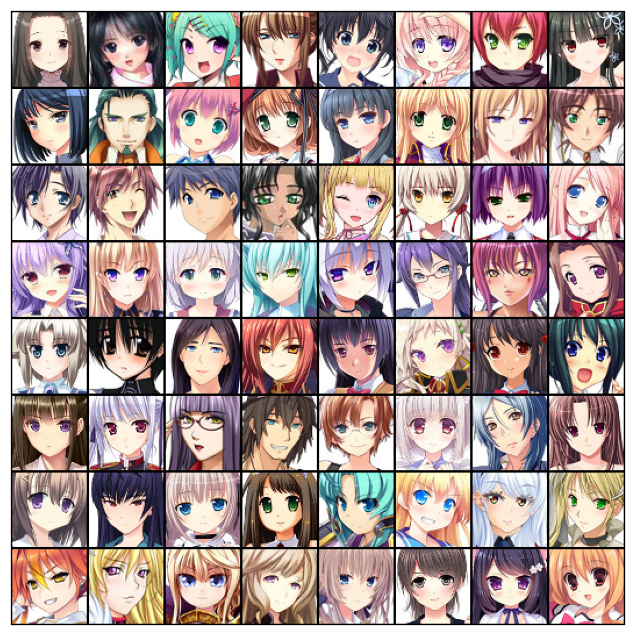

In [ ]:
show_batch(train_dl)

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = torch.nn.functional.relu(self.fc1(x))
        h = torch.nn.functional.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def decoder(self, z):
        h = torch.nn.functional.relu(self.fc4(z))
        h = torch.nn.functional.relu(self.fc5(h))
        return torch.nn.functional.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 4096))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=4096, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [ ]:
optimizer = torch.optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x.view(-1, 4096), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_dl):
        data = data.cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_dl.dataset)))

In [ ]:
for epoch in range(1, 10):
    train(epoch)

====> Epoch: 1 Average loss: 8539.5788
====> Epoch: 2 Average loss: 8539.5567
====> Epoch: 3 Average loss: 8539.5978
====> Epoch: 4 Average loss: 8539.4865
====> Epoch: 5 Average loss: 8539.5872
====> Epoch: 6 Average loss: 8539.5959
====> Epoch: 7 Average loss: 8539.6548
====> Epoch: 8 Average loss: 8539.5439
====> Epoch: 9 Average loss: 8539.5799


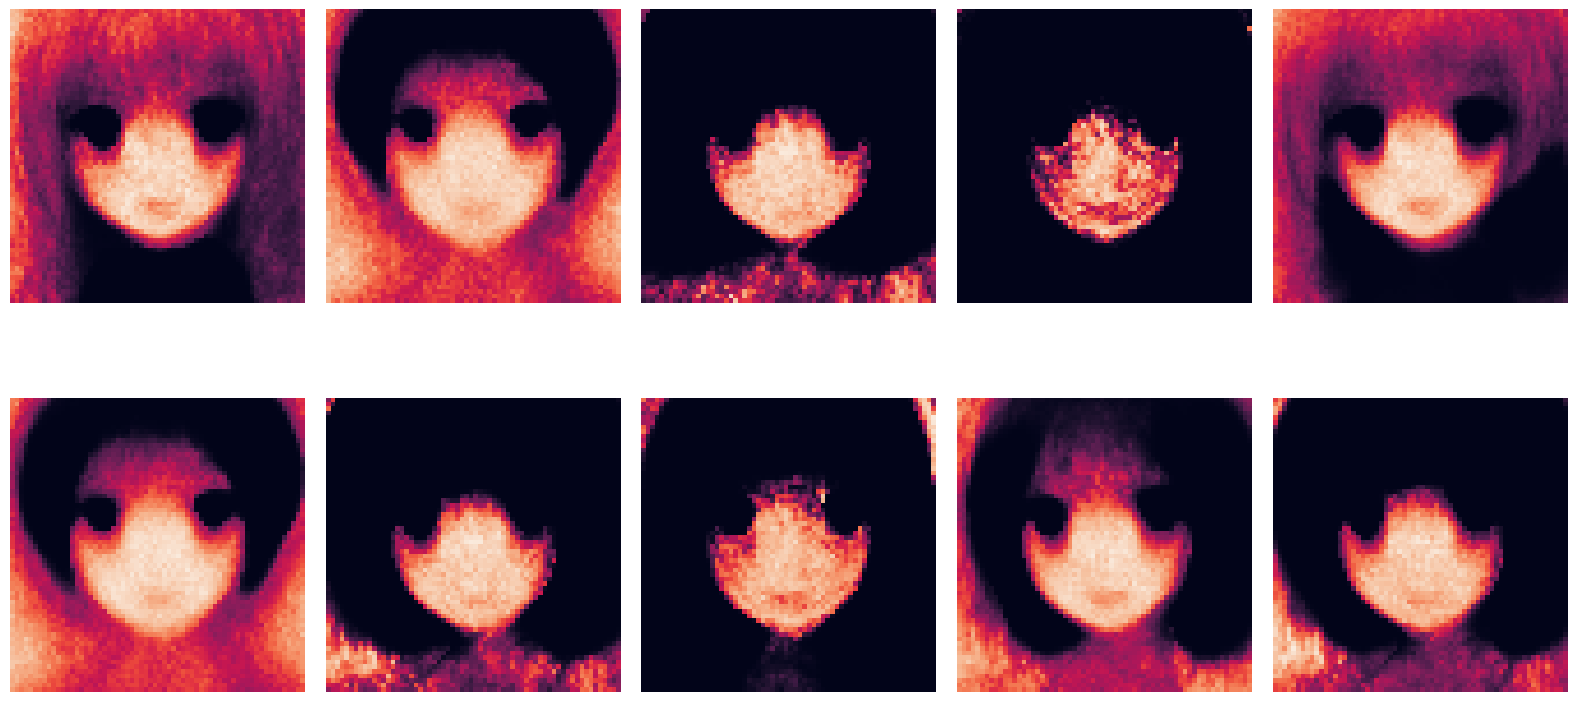

In [ ]:
not_random_values = np.array([
  [-4, -4],
  [-4, 4],
  [4, 4],
  [4, -4],
  [-2, -2],
  [-2, 2],
  [2, 2],
  [2, -2],
  [0, 0],
  [1, 1]
])
dev = torch.device('cuda')
to_restore = torch.FloatTensor(not_random_values).to(dev)
restored = vae.decoder(to_restore)

plt.figure(figsize=(16,9))
for x in range(5):
  for y in range(2):
    plt.subplot(2, 5, y * 5 + x + 1)
    plt.axis('off')
    plt.imshow(restored[y * 5 + x].view(64,64).cpu().detach())
plt.tight_layout()
plt.show()